# Data evaluation hands-on


This iPython notebook is designed to fully evaluate the data in experiment [ILL-DATA.TEST-2385](https://doi.ill.fr/10.5291/ILL-DATA.TEST-2385) and generate all figures which are needed for the paper.

All the work is done in 2 steps:

1. Downloading the data (optional)
2. Evaluating the data

## Downloading the data

In order to be sure, that we have not modified original data, it is recommended to download them [from source][1]

Actually ILL dataportal is not very friendly for getting all data programatically and it is not possible to download the data without ILL credentials. We have written automatic script, using requests and BeutifulSoup packages, which will create HTTPS session to data.ill.fr server, then you need to provide ILL user credentials. Currently the way how to get the ILL credentials is to register in [The ILL User Club][2]. After entering correct credentials, the script will download download all datafiles from the rawdata directory fo the experiment.

This aproach has several disadvantages and can stop working at any time:
- ILL can change the structure of login page
- ILL can change the way how to download the data
- ILL can change the way how to register to the userclub

If the automatic data download will not work, you can follow the [original published data doi link][1] and download the data manually. Then you can manually upload them the rawdata folder.

In case you do not want to do it, we provide the original data as a part of this repository. So they are already in the rawdata directory and you can skip the next step. In that case you need to trust us that provided data are the same as original data, since ILL is not providing any control checksum of the data.

Just select next cell and press SHIFT + ENTER. Then enter username and password for ill.eu. Empty username will result in skipping next step.

[1]: https://doi.ill.fr/10.5291/ILL-DATA.TEST-2385
[2]: https://userclub.ill.eu/

In [15]:
# import libraries i will need
# for downloading files from itnernet
import requests
# for parsing html data
from bs4 import BeautifulSoup
# for creating folder
import os
# for entering password
import getpass

user = input("Enter username for data.ill.fr: ")
pw = getpass.getpass("Enter password for data.ill.fr: ")

if user == '':
    raise ValueError('You have not entered any ILL username. The downloading of the data will be skipped.')

payload = {
    'username': user,
    'password': pw
}
data_url = 'https://data.ill.eu/proposal/getfile?download=1&file=142/in3/exp_TEST-2385/rawdata/%06d'

if not os.path.exists('rawdata'):
    os.mkdir('rawdata')

with requests.Session() as sess:
    res = sess.get('http://data.ill.fr/')
    signin = BeautifulSoup(res._content, 'html.parser')
    url = signin.find('form', id='kc-form-login')['action']
    res = sess.post(url, data=payload)
    print('Downloading datafiles: ', end='')
    for numor in range(84860, 84906):
        r = sess.get(data_url % numor, allow_redirects=True)
        if 'text/plain' in r.headers['Content-Type']:
            open('rawdata/%06d' % numor, 'wb').write(r.content)
            print(f'{numor} ', end='')
        else:
            raise ValueError('The script is not able to download datafiles, either you have provided wrong ILL credentials or the format of the ILL webportal is changed.')

## Evaluating the data

Just show the datafile 84905, which we will evaluate (previous datafiles are just sample alignment).

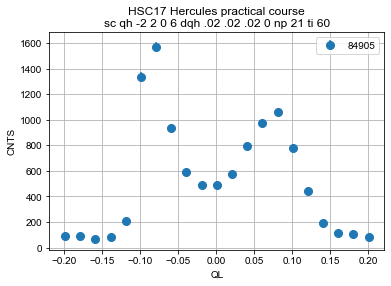

In [19]:
%matplotlib inline
from ufit.lab import *

# set a template, so that data can be referenced by number only
set_datatemplate('rawdata/%06d')
# read one dataset from a file, with given X and Y columns
data = read_data(84905, 'QL', 'CNTS')

data.plot()
show()

### Fitting the data

We are using simple model of two Gaussians which have symmetric position around the zero.

Fit results for 84905
> Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
--------------------------------------------------------------------------------
bkgd            =     69.616 +/-     27.681
p1_pos          =   0.070695 +/-  0.0025657
p1_ampl         =     969.19 +/-     126.86
p1_fwhm         =   0.092633 +/-   0.010258
p2_pos          =  -0.070695 +/-          0 (fixed: -p1_pos)
p2_ampl         =     1265.4 +/-     174.32
p2_fwhm         =   0.061897 +/-  0.0065872
chi^2/NDF       =       43.9


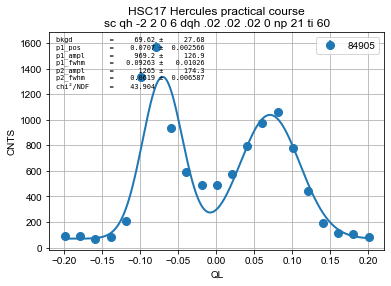

In [20]:
# create a model of a simple Gaussian peak with given initial guess
model = Background() + Gauss('p1', pos=0.1, ampl=100, fwhm=0.1) + Gauss('p2', pos='-p1_pos', ampl=100, fwhm=0.1)

# fit the model, then print and plot the result
result = model.fit(data)
result.printout()
result.plot()
show()

### Nicer plot

Now we plot previously fitted data in nicer way suitable for publication and save it to eps file.

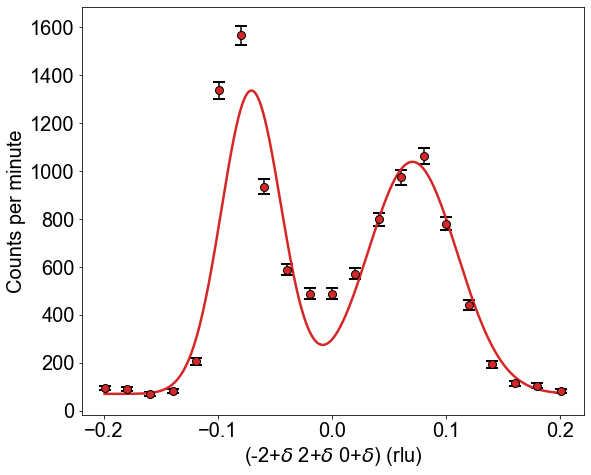

In [22]:
rcParams.update({'font.size': 20})
fig = figure(figsize=(9.0, 7.5))
data.plot(color="C3", mec="k", ms=8, capsize=6, ecolor="k", capthick=2)
model.plot(data, color="C3", lw=2.5)
title("")
legend().set_visible(False)
xlabel("(-2+$\delta$ 2+$\delta$ 0+$\delta$) (rlu)", fontsize=20)
ylabel("Counts per minute", fontsize=20)

grid(False)
savefig("energy-scan.pdf", bbox_inches='tight')
show()

### Conversion of results

Now we convert energy where the constant energy scan was taken to the units used in [paper we want to compare with](https://doi.org/10.1103/PhysRevB.74.054302) (cm$^{-1}$). 

In [25]:
energy = result.data.meta["EN"]
energy *= 8.065 # conversion of meV to cm-1
print(energy)

48.189988


### Plot the results

Last code will plot the resulting excitation to the Energy vs. Position in Brillouin zone dependence. As a background of the plot was used part of the Fig. 3 from [Aouissi paper](https://doi.org/10.1103/PhysRevB.74.054302).

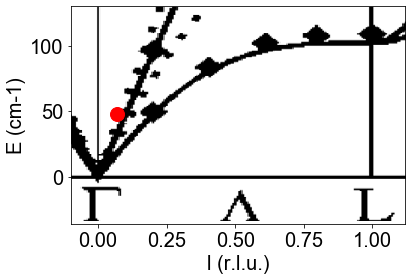

In [26]:
img = imread("phonon.png")
fig, ax = subplots()
errorbar([result.paramvalues['p1_pos']], [energy], xerr=result.paramerrors['p1_pos'], fmt='ro', ms = 14)
ax.imshow(img, extent=[-0.1, 1.12, -36, 130], aspect='auto')
savefig("dispersion.pdf", bbox_inches='tight')
xlabel("l (r.l.u.)")
ylabel("E (cm-1)")
show()